## Project: Feed Forward Neural Network for Digits Classification

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=1Lz0yDZKj9zZdhGL1Zr9IbdEGfPzB56q0" width="100%"/>
</a>
<center/>
<center> Figure. PyTorch Training Overview </center>

<center>
<a href="http://yann.lecun.com/exdb/mnist/">
<img src="https://drive.google.com/uc?export=view&id=13JlBCTfoRd0hzkuf3txMvyU2dI9jga7_" width="100%"/>
</a>
<center/>
<center> Figure. MNIST Handwritten digits dataset </center>

In [ ]:
!pip install scikit-plot

In [ ]:
import time
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os as os

# import below needed torch-based libraries
from ...
from ...
from ...
from ...
from sklearn.metrics import confusion_matrix

#### General settings

In [ ]:
# Device
device = ...

# Hyperparameters
random_seed = 1
learning_rate = 0.1
num_epochs = ... # number of epochs over which the MLP is going to be trained

# Architecture
num_features = ... # number of input features
num_hidden_1 = ... # number of neurons in first hidden layer
num_hidden_2 = ... # number of neurons in second hidden layer
num_classes = ... # number of output classes

dataset_dir = 'data'

num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = ...   # Using minibatches of 128 samples

#### Dataset

In this example, we will use the standard [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
The MNIST dataset contains of handwritten digits (i.e. 0 to 9) and is used in image classification.

In [ ]:
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid

# Load the dataset for the training/validation sets
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_valid_dataset = ... # get MNIST train dataset. This datataset will later on be splitted onto training and validation dataset.

# 60K images of 28x28 pixels

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = ...

In [ ]:
test_dataset = ... # get MNIST test dataset.
# 10K images of 28x28 pixels

##### Loading Dataset
**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.

In [ ]:
train_loader = ... # initialise train data loader

valid_loader = ... # initialise validation data loader

test_loader = ... # initialise test data loader

In [ ]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


Visualize some of the training images

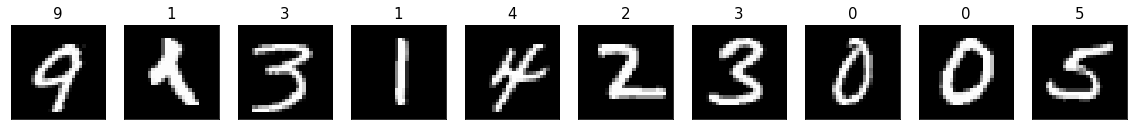

In [ ]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = ...

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Visualize some of the testing images

In [ ]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = ... # get some sample images and labels

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Visualize some of the testing images

In [ ]:
nsamples=10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs, labels = ... # get some sample images and labels

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Model
Whenever we create a neural network in PyTorch, we have to define the `__init__()` and `forward()` methods. PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Our first MLP includes 1x fully-connected layers (i.e. classifier) and is a linear classifier, i.e. we perform logistic regression. As a reminder, in logistic regression, given an input image $x \in \mathbb{R}^{28\times 28}$, we compute scores for each class $k$ as $w_k^T x$, that we pass through the softmax function to get probabilities over the classes :
$$
P(y=k / x) = \frac{e^{w_k^T x}}{\sum_{j=0}^{9} e^{w_j^T x}}
$$

In Pytorch, it is good practice to define class models by subclassing/inheriting from `torch.nn.Module` which provides deep learning methods. Subclassing the Module class usually consists only in redefining the `constructor (init)` and the `forward` method.

In addition, note that by running the forward pass, the input images (x) go through the neural network and generate outputs (logits).

In [ ]:
device = ...

In our MLP, we consider 2x fully-connected layers (i.e. fc1 and classifier). Note that we've a non-linear ReLU layer in between.

In [ ]:
class MLPNet(torch.nn.Module):
    def __init__(self, input_size, num_hidden, num_classes):
        super(MLPNet, self).__init__()
        
        self.num_classes = ...
        
        # define 1st hidden/linear layer
        self.fc1 = ...

        # define output layer
        self.classifier = ...

    def forward(self, x):
        z1 = ...
        a1 = ...

        logits = ... #z3, pre-activation
        probas = ... # a3, softmax
        return ..., ... # return logits and probas

In [ ]:
input_size = 1*28*28 # 784
num_classes = 10
num_hidden = 100

In [ ]:
model = ... # initialise model here

### Loss function

Pytorch provides the 
[torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss)
loss function that computes the softmax followed by the cross entropy.

Consider a 3-class problem. Let us take
an input, of true class y=1, being assigned the scores
$\hat{z} = [-100, 10, 8]$, i.e. the assigned probabilities being
$\hat{y} = [\frac{\exp(-100)}{\sum_i \exp(y_i)}, \frac{\exp(10)}{\sum_i \exp(y_i)}, \frac{\exp(8)}{\sum_i \exp(y_i)}] = [0.0000, 0.8808, 0.1192]$
the cross entropy loss is given by $-\sum_{i=0}^{3} \log(\hat{y}_y) = -\log(0.8808) \approx 0.1269$
and is computed in Pytorch as :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
f_loss(torch.Tensor([[-100, 10, 8]]), torch.LongTensor([1]))
# This prints :   torch.Tensor(0.1269)
```

For now, back to our experiment, we just need to instantiate the loss :

``` {.sourceCode .python}
f_loss = torch.nn.CrossEntropyLoss()
```

Alternatively, you can use the [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#nll-loss) function and pass as parameter the result of having applied the `F.log_softmax( )` to your inputs.

In [ ]:
loss = ... # define your loss function here

### Optimizer

In order to update the model parameters using the computed gradients (`backward()`), we need  to define an optimizer which as its names says, it optimizes the parameters of a neural network is
performed by some kind of gradient descent. In PyTorch there are different optimizers
provided in the [torch.optim
package](https://pytorch.org/docs/stable/optim.html). We will focus on the [SGD
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.sgd) and on the
[Adam
optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam), which are two of the most common and stable optimizers. For that purposes, the optimizer needs a reference to the parameters that it needs
to modify.

``` 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```

In [ ]:
optimizer = ... # define your optimizer here, e.g use SGD

#### Train

Training a neural network involves iterating over the mini-batches of the training set and, for each mini-batch, computing the forward- and backward- propagations to provide the optimizer the gradient from which it can update the model parameters.

In [ ]:
def compute_accuracy_and_loss(model, data_loader, device):
    
    correct_pred, num_examples = 0, 0
    
    cross_entropy = 0.

    for ii, (features, targets) in enumerate(data_loader):
            
        features = ... # [128,28,28]->[128,784], flatten features and put them on GPU's memory.
        targets = ... # y, place labels on GPU's memory

        logits, probas = ... # forward propagation, get logits and probas: z=logits, a=f(z)
        cross_entropy += ... # compute cross-entropy loss between gt's and predictions

        _, predicted_labels = torch.max(probas, 1) # y_hat=predicted_labels
        num_examples += targets.size(0)

        correct_pred += (predicted_labels == targets).sum()

    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [ ]:
def train(model, num_epochs, train_loader, valid_loader):
  
  minibatch_cost = []
  train_acc_lst, valid_acc_lst = [], []
  train_loss_lst, valid_loss_lst = [], []

  best_acc = 0
  best_loss = np.inf

  start_time = time.time()
  for epoch in range(num_epochs):

      model.train()

      for batch_idx, (features, targets) in enumerate(train_loader):
          
          features = features.view(-1, 28*28).to(device) # [128,28,28] => [128,784]
          targets = targets.to(device) # [128]
              
          # forward-propagation
          logits, probas = ...

          # compute cost function
          cost = ...

          # clean gradients
          optimizer.zero_grad()
          
          # compute derivatives
          cost...

          # append minibatch cost
          minibatch_cost.append(cost.item())
          
          # update model parameters
          ... # w = w - learning_rate * partial_deriv_error
          
          # logging results
          if not batch_idx % 50:
              print ('Epoch: %05d/%05d | Batch %05d/%05d | Cost: %.4f' 
                    %(epoch+1, num_epochs, batch_idx, 
                      len(train_loader), cost))
              
      with torch.set_grad_enabled(False):
          train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=device)
          valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=device)

          print('Epoch: %05d/%05d | Train cost: %.4f | Valid cost: %.4f | Train acc.: %.4f%% | Val.acc.: %.4f%%' % (
                epoch+1, num_epochs, 
                train_loss,
                valid_loss,
                train_acc,
                valid_acc))
          
          train_acc_lst.append(train_acc)
          valid_acc_lst.append(valid_acc)
          train_loss_lst.append(train_loss)
          valid_loss_lst.append(valid_loss)

          if valid_acc > best_acc:
            best_acc = valid_acc
            print('Better model: saving to disk.')
            state = {
              'model': model.state_dict(),
              'best_acc': best_acc,
              'epoch': epoch,
              'optimizer': optimizer.state_dict(),
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')

          
      print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
      
  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

  return minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst

In [ ]:
minibatch_cost, train_loss_lst, valid_loss_lst, train_acc_lst, valid_acc_lst = ... # train model

Epoch: 001/010 | Batch 000/375 | Cost: 2.3019
Epoch: 001/010 | Batch 050/375 | Cost: 0.7893
Epoch: 001/010 | Batch 100/375 | Cost: 0.4692
Epoch: 001/010 | Batch 150/375 | Cost: 0.4472
Epoch: 001/010 | Batch 200/375 | Cost: 0.4581
Epoch: 001/010 | Batch 250/375 | Cost: 0.4929
Epoch: 001/010 | Batch 300/375 | Cost: 0.5501
Epoch: 001/010 | Batch 350/375 | Cost: 0.4047
Epoch: 001/010 | Train cost: 0.0033 | Valid cost: 0.0033 | Train acc.: 88.78% | Val.acc.: 89.45%
Time elapsed: 0.16 min
Epoch: 002/010 | Batch 000/375 | Cost: 0.4245
Epoch: 002/010 | Batch 050/375 | Cost: 0.4172
Epoch: 002/010 | Batch 100/375 | Cost: 0.3815
Epoch: 002/010 | Batch 150/375 | Cost: 0.3648
Epoch: 002/010 | Batch 200/375 | Cost: 0.3289
Epoch: 002/010 | Batch 250/375 | Cost: 0.4786
Epoch: 002/010 | Batch 300/375 | Cost: 0.3514
Epoch: 002/010 | Batch 350/375 | Cost: 0.2142
Epoch: 002/010 | Train cost: 0.0029 | Valid cost: 0.0028 | Train acc.: 89.96% | Val.acc.: 90.37%
Time elapsed: 0.31 min
Epoch: 003/010 | Batch 0

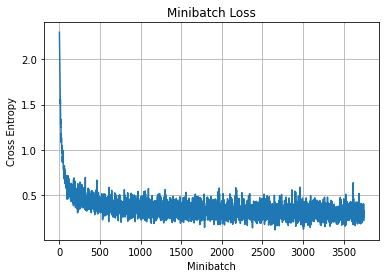

In [ ]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.title('Minibatch Loss')
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.grid()
plt.show()

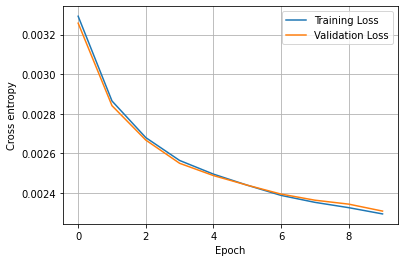

In [ ]:
plt.plot(range(len(train_loss_lst)), train_loss_lst, label='Training Loss')
plt.plot(range(len(valid_loss_lst)), valid_loss_lst, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

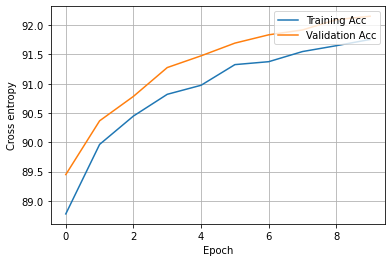

In [ ]:
plt.plot(range(len(train_acc_lst)), train_acc_lst, label='Training Acc')
plt.plot(range(len(valid_acc_lst)), valid_acc_lst, label='Validation Acc')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.grid()
plt.show()

Once the model has been trained, we can evaluate the model's performance on an **unseen** testing dataset. For that purposes, we are going to use the `compute_accuracy` function together with the `test_loader`.

In [ ]:
test_acc, test_loss = ... # compute accuracy
print('Test accuracy: %.2f%%' % (test_acc))

Test accuracy: 91.99%


In [ ]:
# obtain one batch of test images
data_iter = iter(test_loader)
images, targets = data_iter.next()

In [ ]:
# get sample outputs
logits, probas = ...

# convert output probabilities to predicted class
_, preds = ...

In [ ]:
targets

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

In [ ]:
preds

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 4, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 4, 9, 0, 5])

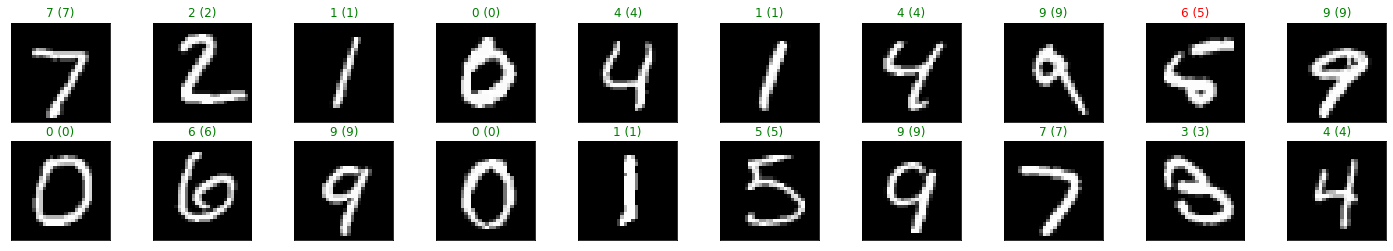

In [ ]:
# plot the images in the batch, along with predicted and true targets
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(targets[idx].item())),
                 color=("green" if preds[idx]==targets[idx] else "red"))

In [ ]:
cm = ...

In [ ]:
print(cm)

[[10  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  1  0  0]
 [ 0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  1  0  0  0]
 [ 0  0  0  0  0  9  1  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  1  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  1  0  0  0  0 16]]


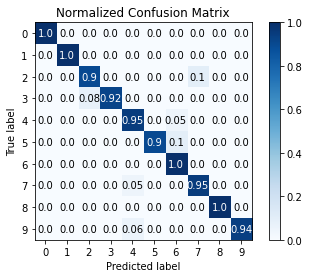

In [ ]:
skplt.metrics.plot_confusion_matrix(targets,preds, normalize=True)

## Discussion

Multilayer Perceptrons can show some limitations. To summarize some of these issues, we have:

1. Training time: most of the modern neural networks need from hundreds up to thousands of iterations to reach their highest accuracy. This has been a point of criticism, specially because human learning seems to be way more efficient. 
2. Architectural decisions: finding the perfect or an efficient MLP architecture might involve performing many experiments and searching over a large size of hyperparameters. This is mainly because we are trying to solve a non-convex optimisation problem.
3. Biological plausibility of backpropagation: there is no clear evidence that our brain learns via backpropagation, therefore, defining *biologically plausible* models is an on-going research topic.

